# LANL Earthquake Prediction Kaggle Competition 2019
### Eric Yap, Joel Huang, Kyra Wang

---

In this notebook, we present our work for the LANL Earthquake Prediction Kaggle Competition 2019. The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, we need to predict a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake.

---

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Data wrangling imports
import numpy as np
import pandas as pd

# Utility imports
import ast
from tqdm import tqdm, tqdm_notebook, trange
from joblib import Parallel, delayed

# Data visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms

# Custom stuff
from series_data import LANLDataset, FeatureGenerator

# Setting the seeds for reproducibility
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
else:
    torch.manual_seed_all(42)

### Data preprocessing

As the training data and the test data are formatted differently, we must either preprocess the data such that the formats of both sets are the same, or ensure that our model is capable of predicting on the two different formats. We went with the first option because it is less time consuming to implement.

We did this by splitting the training data into segments the same size as the test data segments, i.e. 150000 data points each. Each segment is labeled with a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake. We then put each of these segments into a single dataframe, and saved this as a pickle file to be used as our training data.

Following this, we merged the separate test segments into another single dataframe, and saved this as a pickle file to be used as our test data.

As the dataset is massive, we used Joblib to help run the functions as a pipeline jobs with parallel computing.

In [2]:
trainval_df = pd.read_pickle('./data/train_features.pkl')
trainval_df = trainval_df[:-2]
train_segments = np.array([seg for seg in trainval_df['segment'].to_numpy()])
train_labels = trainval_df['target']

# Code to interpolate labels
# for i in range(len(train_labels)):
#     current = train_labels.loc[i].to_frame()
#     future = train_labels.loc[i+1].to_frame()
#     nans = np.full((149998, 1), np.nan)
#     v = pd.DataFrame(np.vstack([current, nans, future])).interpolate()
#     break

In [3]:
test_df = pd.read_pickle('./data/test_features.pkl')
test_segments = np.array([seg for seg in test_df['segment'].to_numpy()])
test_labels = test_df['target']

At this point, we split the training data further into a 80/20 training/validation split. We then create dataloaders that will help load the data into the model in parallel using multiprocessing workers.

# Time Series Feature Extraction
https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

The idea is to chop up the 150k-sized sample into a sequence which we can run some time series prediction on. Maybe the RNN can pick up on the two classes of signals as described in https://public.lanl.gov/geophysics/geophysics/nonlinear/2017/Rouet-LeducGRL17.pdf, if the features are present in the chopped up segments.

## Early features
Some features are sensitive to changes in signal characteristics early in time during the stress cycle. From the paper:
> We find that statistics quantifying the signal amplitude distribution (e.g., its variance and higher-order moments) are highly effective at forecasting failure. The variance, which characterizes overall signal amplitude fluctuation, is the strongest single feature early in time.

## Just before failure
Important features - window threshold, window kurtosis, window variance
> As the system nears failure, other outlier statistics such as the kurtosis and thresholds become predictive as well.

Initial idea - chop up to the size of a feature. But consider that feature signals might additively overlap.

In [13]:
import multiprocessing
from functools import partial

def create_features(seg_id, n, seg, x):
    w = pd.Series(seg)
    if w.std() == np.nan:
        raise Exception('Got some nans.')
    x.loc[(seg_id, n), 'std'] = w.std()
    x.loc[(seg_id, n), 'var'] = w.var()
    x.loc[(seg_id, n), 'kurt'] = w.kurtosis()
    x.loc[(seg_id, n), 'mean'] = w.mean()
    x.loc[(seg_id, n), 'max'] = w.max()
    x.loc[(seg_id, n), 'thresh'] = (w.mean() - 5) * ((w.mean() - 5) > 0)

def multi_process_features(process_id, split_segments, num_processes, partition_size,
                           segments, num_windows, window_size):
    segment_start = int(process_id * partition_size)
    segment_end = int(segment_start + partition_size)
    if process_id == num_processes - 1:
        segment_end = segments
    partition = segment_end - segment_start
    multi_index = pd.MultiIndex(levels=[np.arange(partition), np.arange(num_windows)],
                                codes=[np.repeat(np.arange(partition), num_windows),
                                       np.tile(np.arange(num_windows), partition)])
    split_features = pd.DataFrame(index=multi_index, dtype=np.float64)        
    for seg_id in tqdm(np.arange(partition)):
        for n in np.arange(num_windows):
            seg = split_segments[seg_id, n * window_size : n * window_size + window_size]
            create_features(seg_id, n, seg, split_features)
    return split_features

def compute_features(split_segments):
    window_size = 100
    rows = 150000
    segments = split_segments.shape[0]
    num_windows = int(rows / window_size)
    num_processes = 16
    partition_size = np.floor(segments / num_processes)
    pool = multiprocessing.Pool(processes=num_processes)
    partial_process = partial(multi_process_features,
                              split_segments=split_segments, num_processes=num_processes,
                              partition_size=partition_size, segments=segments,
                              num_windows=num_windows, window_size=window_size)
    dataframes = pool.map(partial_process, np.arange(0, num_processes))
    pool.close()
    pool.join()

    return pd.concat(dataframes)

def compute_features_sequential(train_segments):
    window_size = 100
    rows = 150000
    segments = train_segments.shape[0]
    num_windows = int(rows / window_size)
    multi_index = pd.MultiIndex(levels=[np.arange(segments), np.arange(num_windows)],
                                codes=[np.repeat(np.arange(segments), num_windows),
                                       np.tile(np.arange(num_windows), segments)])
    features = pd.DataFrame(index=multi_index, dtype=np.float64)        
    for seg_id in tqdm(np.arange(segments)):
        for n in np.arange(num_windows):
            seg = train_segments[seg_id, n * window_size : n * window_size + window_size]
            create_features(seg_id, n, seg, features)
    return features

In [14]:
def normalize_features(features):
    normalized = ((features - features.mean()) / features.std()).values.reshape(-1, 150, 6)
    print(normalized.shape)
    return normalized

train_features = compute_features_sequential(train_segments)


  0%|          | 2/4193 [00:15<9:04:07,  7.79s/it]

KeyboardInterrupt: 

In [17]:
train_normalized = np.load('./data/normalized_500.npy')
test_normalized = np.load('./data/normalized_test_500.npy')
print(train_normalized.shape)
print(test_normalized.shape)

(4193, 300, 6)
(2624, 300, 6)


In [72]:
batch_size = 50
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 16}

trainval_set = LANLDataset('train', train_normalized, train_labels)
train_set, val_set = trainval_set.train_val_split(0.8, 0.2)
test_set = LANLDataset('test', test_normalized)

datasets = {
    'train': train_set,
    'val' : val_set,
    'test': test_set
}

dataloaders = {phase: data.DataLoader(dataset, **params)
               for phase, dataset in datasets.items()}

class LANLModel(nn.Module):
    def __init__(self, device, input_dim=1, hidden_dim=64, output_dim=1, batch_size=64, num_layers=1):
        super(LANLModel, self).__init__()
        self.device = device
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(2 * self.num_layers * self.hidden_dim, 128)
        self.fc2 = nn.Linear(128, self.output_dim)
        self.to(self.device)

    def init_hidden(self, batch_size):
        return (
            torch.zeros(2 * self.num_layers, batch_size, self.hidden_dim).to(self.device),
            torch.zeros(2 * self.num_layers, batch_size, self.hidden_dim).to(self.device)
        )

    def forward(self, x):
        minibatch_size = x.shape[0]
        rnn_out, hc = self.rnn(x, self.init_hidden(minibatch_size))
        out = self.fc1(hc[0].view(1, minibatch_size, -1))#rnn_out[:,-1,:])
        out = self.fc2(out)
        return out

device = torch.device('cuda')

model_params = {
    "batch_size": batch_size,
    "input_dim": 6,
    "hidden_dim": 96,
    "num_layers": 3
}

model = LANLModel(device, **model_params)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
best_val_loss = np.inf

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for idx, batch in enumerate(dataloaders['train']):
        model.zero_grad()
        features = batch['data'].to(device)
        target = batch['target'].to(device)
        output = model(features)
        loss = criterion(output.float(), target) - 0.1*output.std()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(dataloaders['train'])
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(dataloaders['val']):
            features = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(features)
            loss = criterion(output.float(), target)
            validation_loss += loss.item()
    validation_loss /= len(dataloaders['val'])
    print("Epoch {}\t| Training loss: {}\t| Validation loss: {}".format(epoch, train_loss, validation_loss))
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
#     else:
#         print("Validation loss {} was worse than {}. Stopping.".format(validation_loss, best_val_loss))
#         break

Epoch 0	| Training loss: 3.3139090012101566	| Validation loss: 3.191039295757518
Epoch 1	| Training loss: 3.046015676330118	| Validation loss: 3.065798647263471
Epoch 2	| Training loss: 3.0263650873128105	| Validation loss: 3.153371207854327
Epoch 3	| Training loss: 3.0718884187586166	| Validation loss: 3.0823856662301456
Epoch 4	| Training loss: 3.003477661048665	| Validation loss: 3.075199183295755
Epoch 5	| Training loss: 3.025087907033808	| Validation loss: 3.1615232159109676
Epoch 6	| Training loss: 3.0354720073587753	| Validation loss: 3.1490252017974854
Epoch 7	| Training loss: 3.0287566465490006	| Validation loss: 3.0621359628789566
Epoch 8	| Training loss: 3.015921543626224	| Validation loss: 3.118438299964456
Epoch 9	| Training loss: 3.038772228886099	| Validation loss: 3.068502103581148
Epoch 10	| Training loss: 3.018005041515126	| Validation loss: 3.0670542857226204
Epoch 11	| Training loss: 3.044788458768059	| Validation loss: 3.11661958694458
Epoch 12	| Training loss: 3.0

KeyboardInterrupt: 

### Evaluating the Model on the Test Data

In [73]:
from datetime import datetime

def LANL_test(model, dataloaders, submission_path='./submissions'):
    predictions = {'seg_id': [], 'time_to_failure': []}
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(dataloaders['test']):
            features = batch['data'].to(device)
            start, end = idx, idx + features.shape[0]
            seg_id = test_df['seg_id'][start:end]
            output = model(features).squeeze(0)
            for i in range(features.shape[0]):
                predictions['seg_id'].append(seg_id.values[i])
                predictions['time_to_failure'].append(output[i].item())
    df = pd.DataFrame.from_dict(predictions)
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    df.to_csv(submission_path + '/submission_' + datetime_str + '.csv', index=False)
    return df

LANL_test(model, dataloaders)

,seg_id,time_to_failure
0,seg_00030f,5.803012
1,seg_0012b5,6.947465
2,seg_00184e,6.205505
3,seg_003339,5.363450
4,seg_0042cc,6.213612
5,seg_004314,5.436797
6,seg_004cd2,6.044988
7,seg_004ee5,5.534001
8,seg_004f1f,5.415646
9,seg_00648a,6.045774


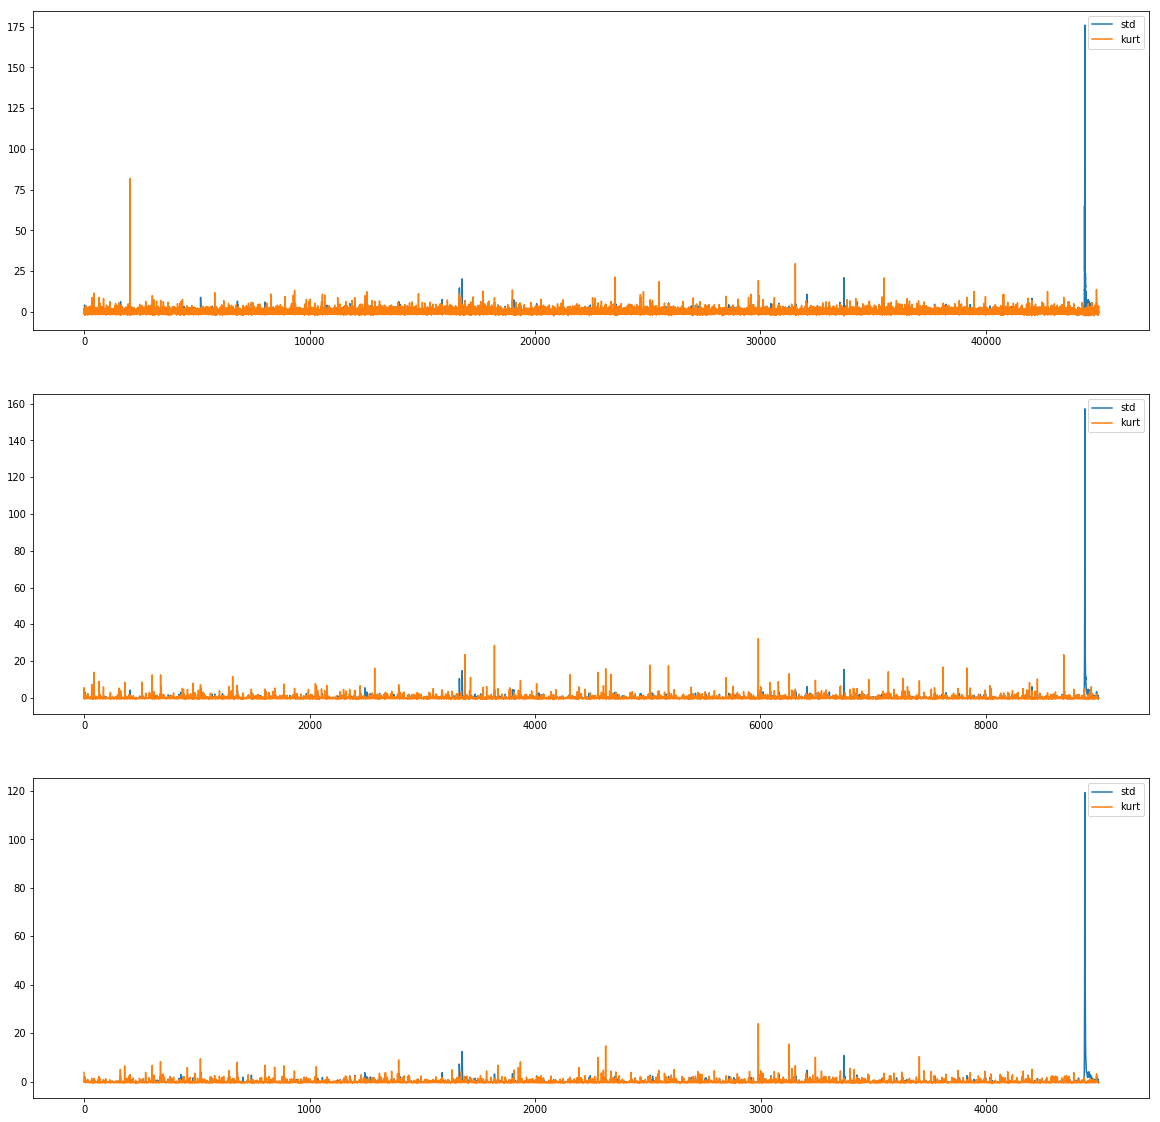

In [95]:
normalized100 = np.load('./data/normalized_100.npy')
normalized500 = np.load('./data/normalized_500.npy')
normalized1000 = np.load('./data/normalized_1000.npy')

plt.figure(figsize=(20,20))

plt.subplot(311)
plt.plot(np.concatenate(normalized100[0:30])[:,0], label='std')
plt.plot(np.concatenate(normalized100[0:30])[:,1], label='var')
plt.plot(np.concatenate(normalized100[0:30])[:,2], label='kurt')
plt.plot(np.concatenate(normalized100[0:30])[:,3], label='mean')
plt.plot(np.concatenate(normalized100[0:30])[:,4], label='max')
plt.plot(np.concatenate(normalized100[0:30])[:,5], label='thresh')
plt.legend()

plt.subplot(312)
plt.plot(np.concatenate(normalized500[0:30])[:,0], label='std')
plt.plot(np.concatenate(normalized500[0:30])[:,1], label='var')
plt.plot(np.concatenate(normalized500[0:30])[:,2], label='kurt')
plt.plot(np.concatenate(normalized500[0:30])[:,3], label='mean')
plt.plot(np.concatenate(normalized500[0:30])[:,4], label='max')
plt.plot(np.concatenate(normalized500[0:30])[:,5], label='thresh')
plt.legend()

plt.subplot(313)
plt.plot(np.concatenate(normalized1000[0:30])[:,0], label='std')
plt.plot(np.concatenate(normalized1000[0:30])[:,1], label='var')
plt.plot(np.concatenate(normalized1000[0:30])[:,2], label='kurt')
plt.plot(np.concatenate(normalized1000[0:30])[:,3], label='mean')
plt.plot(np.concatenate(normalized1000[0:30])[:,4], label='max')
plt.plot(np.concatenate(normalized1000[0:30])[:,5], label='thresh')
plt.legend()

plt.show()